# SARIMAX Example

Working through code from https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
and https://www.machinelearningplus.com/time-series/time-series-analysis-python/

## Time Series 

### Data Exploration

In [8]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Import as Dataframe
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
#df.head()

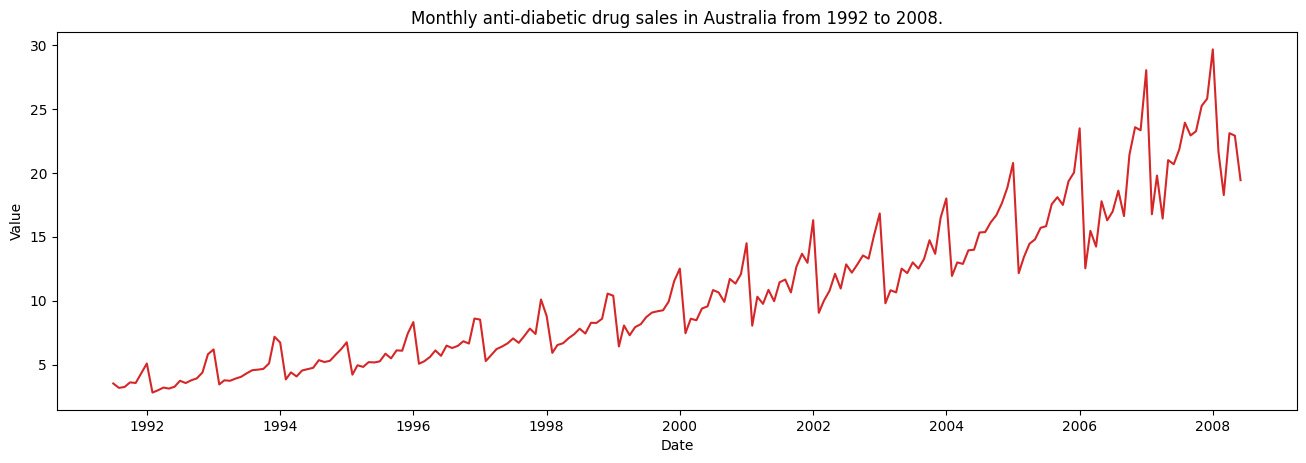

In [5]:
# Time series data source: fpp pacakge in R.
import matplotlib.pyplot as plt
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')    

A yearly spike in the sales can be seen every year, thus we plot each year to see the seasonality of the data

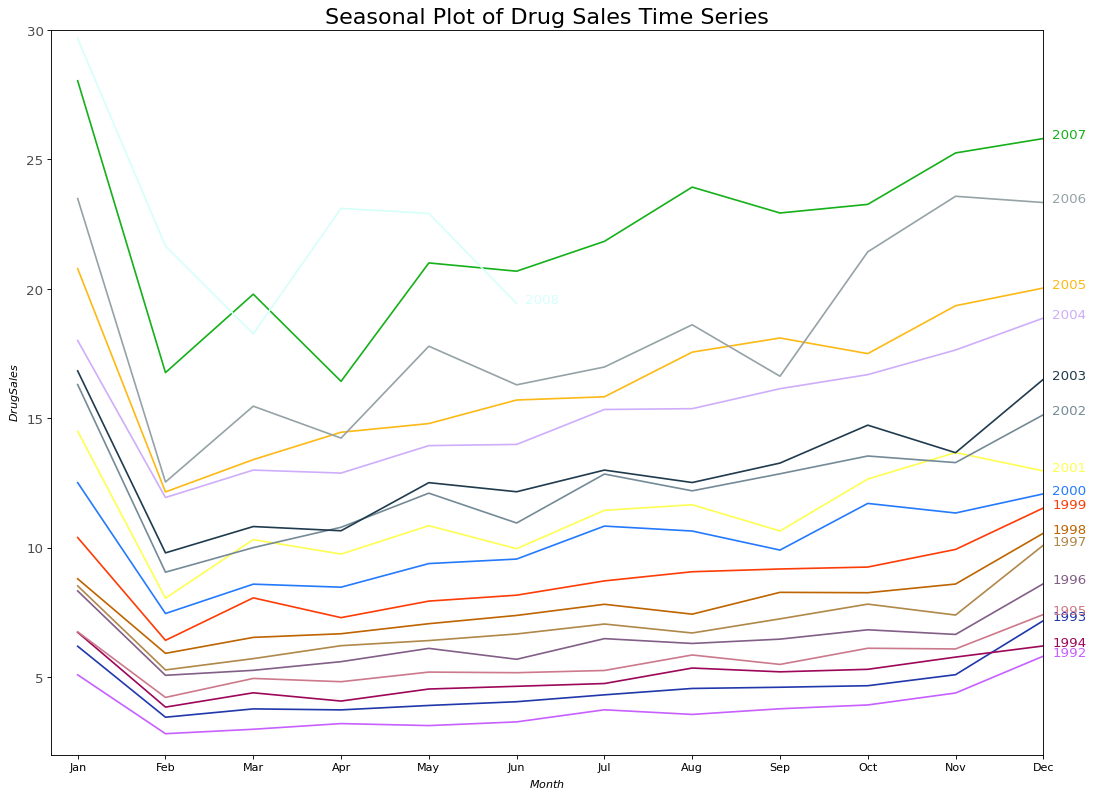

In [9]:
# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
plt.show()

Two characteristics of the data that are clear from this graph are:
* The total number of sales genereally each consecutive year.
* There is a server drop in sales for the month of Feburary and an increase in March every year 

Now we will plot two boxplots to better illustrate this
* Yearly (trend)
* Monthly (seasonality)

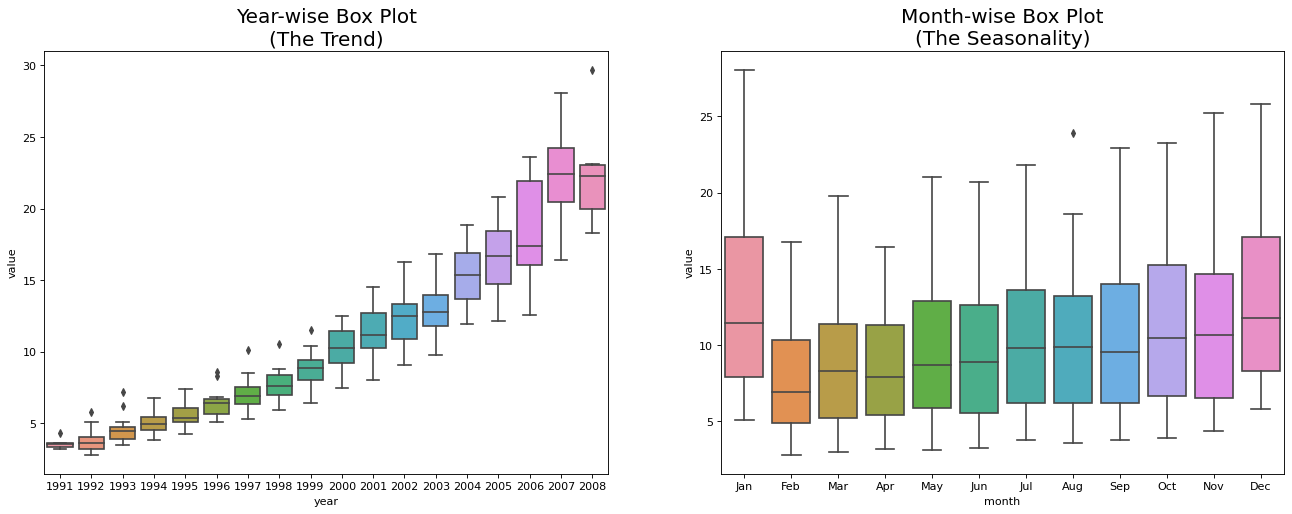

In [10]:
# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

A time series can be represented as:

Current Value = Baseline ( constant ) + Trend ( y = g(x) ) + Seasonality/Cyclical ( y = g( x(n) ) ~ g( x(n+T) ) ) + Error( true_y - esti_y )

Seasonality is connected to date based trends, whereas cyclical data is dependant on some other cycle.

<AxesSubplot:title={'center':'Trend and Seasonality'}, xlabel='date'>

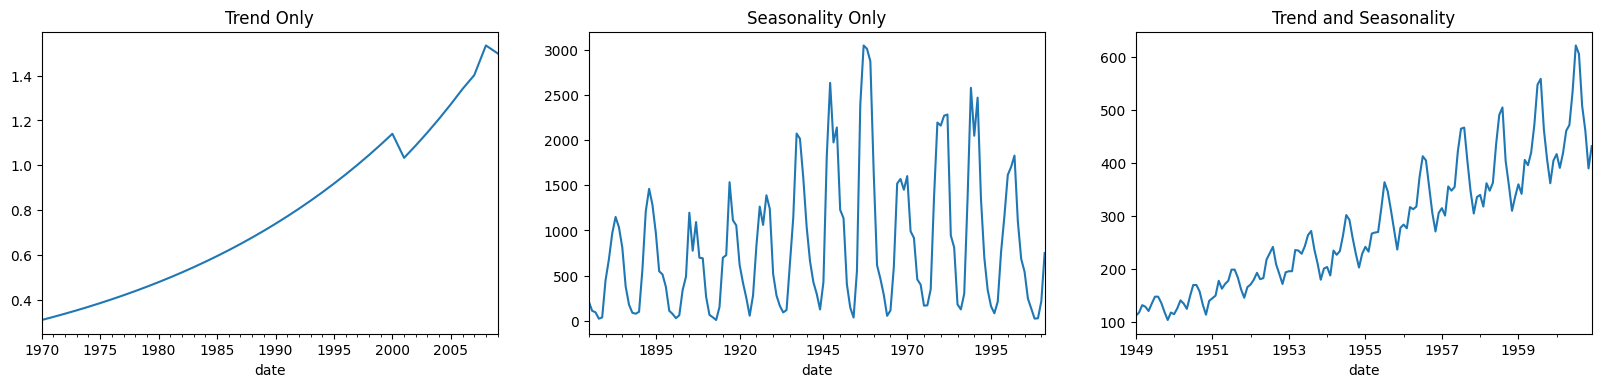

In [11]:
fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])

A series can either be additive or multiplicative in its components

* Additive series = baseline + trend + seasonality + error
* Multiplicative series = baseline * trend * seasonality * error

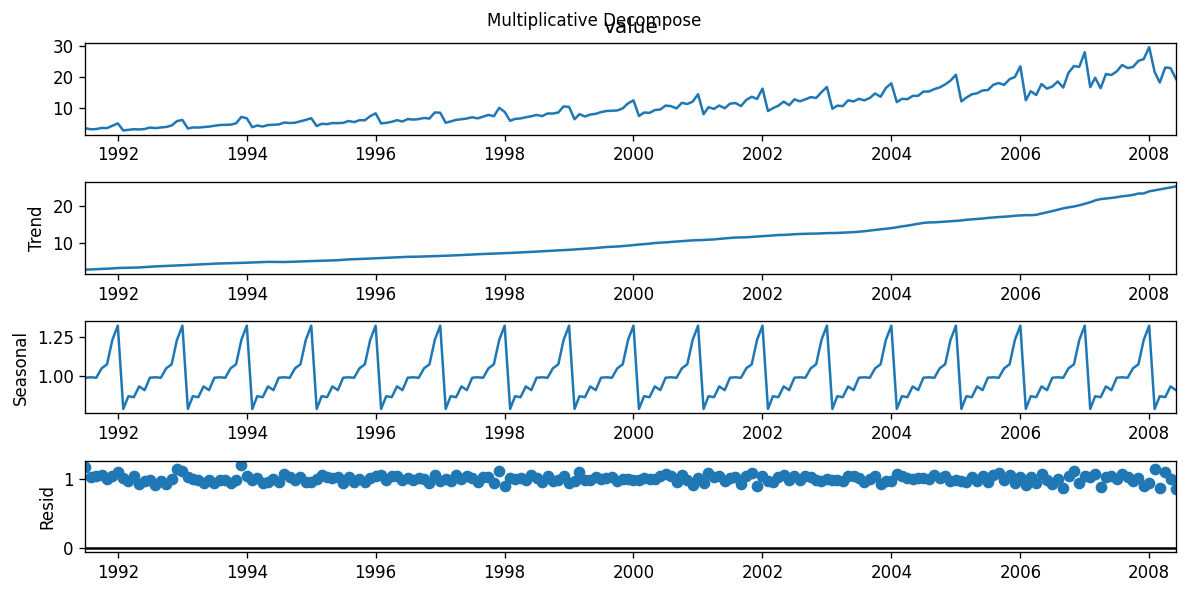

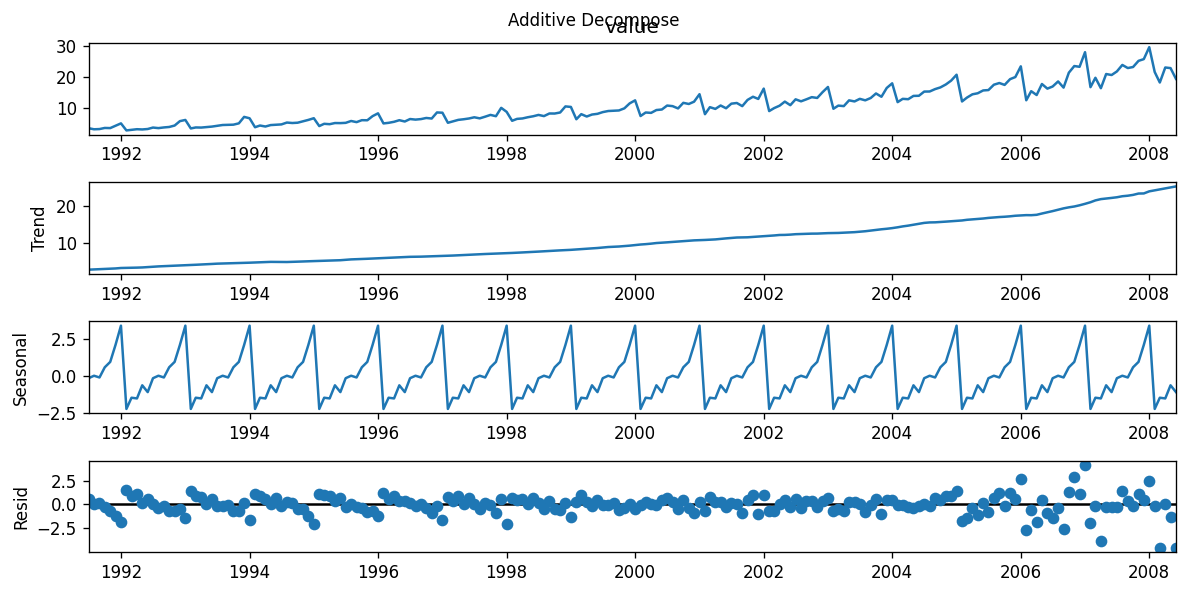

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,5)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=10)
result_add.plot().suptitle('Additive Decompose', fontsize=10)
plt.show()

Setting extrapolate_trend='freq' takes care of any missing values in the trend and residuals at the beginning of the series.

Comparing the residuals:

* Multiplicative: Appears to be white noise(random), which is desired for the error
* Additive: Some of the pattern remains

### Stationarity

A stochastic process **x**(t) is Strict Sense Stationary(SSS) if its statistical properties are invariant to shifts of the origin.
* f(x;t) = f(x;t+c) = f(x) for all c
* f(x_1,x_2;t_1,t_2) = f(x_1,x_2;T) for c=-t2, and T=t_1-t_2

A stochastic process **x**(t) is Wide Sense Stationary(WSS) if 
* E{**x**(t)} = nu (mean is constant)
* R(T), T=t_1-t_2 (Autocorrelation is dependant on time difference and not a particular t)

Note: For WSS process average power = R(0) and is independant of t 


A stationary time series is desired as a AutoRegressive(AR) filter is linear regression with the lagged series used as the predictor. Linear regression performs best when the correlation between variables is small (ideal for independant predictors), which is provided by a stationary time series.

#### Methods to make time series more stationary

* Difference the series (Y_x = Y_t - Y_(t-1))
* Log series (Y_x = log(Y_t))
* Take nth root of the series
* Any combination of the above

#### Test for Stationarity
